In [1]:
"hi"

'hi'

In [2]:
import pandas as pd
url = "https://www.health.state.mn.us/diseases/coronavirus/situation.html#hosp1"

dfs = pd.read_html(url)

In [3]:
for df in dfs:
    print(df.columns)

Index(['Date reported',
       'Completed tests reported from the MDH Public Health Lab (daily)',
       'Completed tests reported from external laboratories (daily)',
       'Total approximate number of completed tests'],
      dtype='object')
Index(['Date reported', 'Change in positive cases (daily)',
       'Total confirmed positive'],
      dtype='object')
Index(['Date reported', 'No longer needing isolation'], dtype='object')
Index(['Date reported', 'Newly reported deaths (daily)', 'Total deaths'], dtype='object')
Index(['County of residence', 'Age group', 'Number of newly reported deaths'], dtype='object')
Index(['Residence type', 'Number of newly reported deaths'], dtype='object')
Index(['Date reported', 'Hospitalized in ICU (daily)',
       'Hospitalized, not in ICU (daily)', 'Total hospitalizations',
       'Total ICU hospitalizations'],
      dtype='object')
Index(['Age Group', 'Percent of Cases', 'Percent of Deaths'], dtype='object')
Int64Index([0, 1, 2], dtype='int64')
Inde

In [4]:
# Want: deaths, ICU/hosp, new cases

cases = dfs[1]
assert "Change in positive cases (daily)" in cases.columns
assert "Total confirmed positive" in cases.columns
deaths = dfs[3]
assert "Newly reported deaths (daily)" in deaths.columns
assert "Total deaths" in deaths.columns

icu = dfs[6]
print(icu.columns)
assert "Hospitalized in ICU (daily)" in icu.columns
assert "Total ICU hospitalizations" in icu.columns

Index(['Date reported', 'Hospitalized in ICU (daily)',
       'Hospitalized, not in ICU (daily)', 'Total hospitalizations',
       'Total ICU hospitalizations'],
      dtype='object')


In [5]:
df = pd.merge(cases, deaths, on="Date reported")
df = pd.merge(df, icu, on="Date reported")

In [6]:
df.to_csv("data/mn.csv", index=False)

In [7]:
df.head()

,Date reported,Change in positive cases (daily),Total confirmed positive,Newly reported deaths (daily),Total deaths,Hospitalized in ICU (daily),"Hospitalized, not in ICU (daily)",Total hospitalizations,Total ICU hospitalizations
0,3/21,22,137,1,1,4,2,12,4
1,3/22,32,169,0,1,5,5,12,5
2,3/23,66,235,0,1,5,7,21,5
3,3/24,26,261,0,1,7,8,25,7
4,3/25,26,287,0,1,12,14,35,12


In [8]:
from datetime import datetime, timedelta

def parse_datetime(x):
    month, day = x.split("/")
    return datetime(2020, int(month), int(day))

df["datetime"] = df["Date reported"].apply(parse_datetime)
assert (df.columns == ['Date reported', 'Change in positive cases (daily)',
       'Total confirmed positive', 'Newly reported deaths (daily)',
       'Total deaths', 'Hospitalized in ICU (daily)',
       'Hospitalized, not in ICU (daily)', 'Total hospitalizations',
       'Total ICU hospitalizations', "datetime"]).all()

df.columns

Index(['Date reported', 'Change in positive cases (daily)',
       'Total confirmed positive', 'Newly reported deaths (daily)',
       'Total deaths', 'Hospitalized in ICU (daily)',
       'Hospitalized, not in ICU (daily)', 'Total hospitalizations',
       'Total ICU hospitalizations', 'datetime'],
      dtype='object')

In [9]:
df["in_hosp"] = df["Hospitalized in ICU (daily)"] + df["Hospitalized, not in ICU (daily)"]

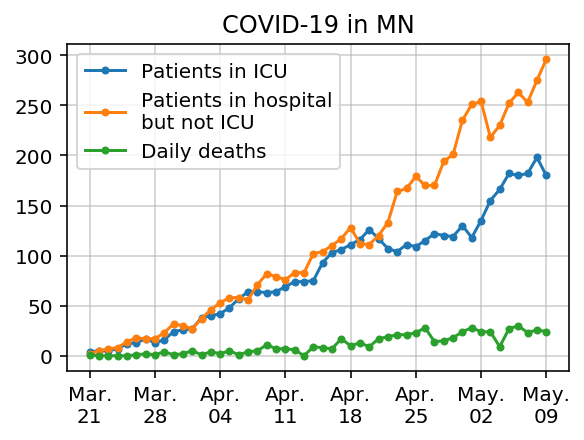

In [18]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

w = 3
fig, ax = plt.subplots(figsize=(1.5 * w, w))

style = ".-"
ax.plot(df.datetime, df["Hospitalized in ICU (daily)"], style, label="Patients in ICU")
ax.plot(df.datetime, df["Hospitalized, not in ICU (daily)"], style, label="Patients in hospital\nbut not ICU")
ax.plot(df.datetime, df["Newly reported deaths (daily)"], style, label="Daily deaths")
# ax.plot(df.datetime, df["Change in positive cases (daily)"], label="New positive tests")
ax.legend(loc="best")
# ax.set_yscale("log")
start = df.datetime.min()
weeks = [start + timedelta(k * 7) for k in range(52)]
ax.xaxis.set_major_locator(plt.FixedLocator([mdates.date2num(_) for _ in weeks]))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b.\n%d"))
ax.grid(alpha=0.6)
ax.set_title("COVID-19 in MN")
# ax.set_ylabel("Number")
fig.savefig("imgs/mn.png", dpi=300, bbox_inches="tight")
fig.savefig("imgs/mn.svg", bbox_inches="tight")